# Densenet Implementation

In [1]:
%%capture
!pip install pydot
!apt-get install graphviz
!sed -i 's/def _check_pydot()/def _check__pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py
!sed -i 's/_check_pydot()/#_check_pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py

In [2]:
import keras
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framewo

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../tob2/data/train"))

['c2.399.jpg', 'c3.642.jpg', 'c1.718.jpg', 'c1.274.jpg', 'c3.756.jpg', 'c1.564.jpg', 'c2.386.jpg', 'c2.327.jpg', 'c3.798.jpg', 'c4.696.jpg', 'c2.321.jpg', 'c2.707.jpg', 'c4.147.jpg', 'c1.496.jpg', 'c1.799.jpg', 'c2.505.jpg', 'c1.477.jpg', 'c2.674.jpg', 'c3.134.jpg', 'c2.529.jpg', 'c2.423.jpg', 'c2.518.jpg', 'c2.591.jpg', 'c1.60.jpg', 'c1.15.jpg', 'c2.755.jpg', 'c2.205.jpg', 'c4.509.jpg', 'c3.86.jpg', 'c3.486.jpg', 'c3.44.jpg', 'c3.113.jpg', 'c3.130.jpg', 'c3.304.jpg', 'c4.113.jpg', 'c2.173.jpg', 'c3.61.jpg', 'c1.150.jpg', 'c1.586.jpg', 'c4.699.jpg', 'c1.478.jpg', 'c3.112.jpg', 'c4.2.jpg', 'c3.173.jpg', 'c2.133.jpg', 'c1.697.jpg', 'c2.495.jpg', 'c4.709.jpg', 'c4.338.jpg', 'c1.661.jpg', 'c4.254.jpg', 'c1.87.jpg', 'c4.546.jpg', 'c1.224.jpg', 'c1.254.jpg', 'c1.172.jpg', 'c2.138.jpg', 'c4.585.jpg', 'c4.563.jpg', 'c1.549.jpg', 'c4.750.jpg', 'c4.603.jpg', 'c4.224.jpg', 'c2.416.jpg', 'c4.727.jpg', 'c4.201.jpg', 'c1.738.jpg', 'c3.382.jpg', 'c3.295.jpg', 'c2.652.jpg', 'c2.510.jpg', 'c2.340.jpg',

In [4]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [5]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
filenames = os.listdir("../tob2/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
earlystop = EarlyStopping(patience=10)

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
callbacks = [earlystop, learning_rate_reduction]

In [11]:
df["category"] = df["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [12]:
total_train =df.shape[0]

batch_size=15

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df, 
    "../tob2/data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 4 classes.


In [14]:
df = df.reset_index(drop=True)
df

,filename,category
0,c2.399.jpg,c2
1,c3.642.jpg,c3
2,c1.718.jpg,c1
3,c1.274.jpg,c1
4,c3.756.jpg,c3
...,...,...
3195,c1.578.jpg,c1
3196,c4.511.jpg,c4
3197,c2.231.jpg,c2
3198,c1.500.jpg,c1


In [15]:
filenames = os.listdir("../tob2/data/validation")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df1 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [16]:
df1["category"] = df1["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [17]:
df1 = df1.reset_index(drop=True)

In [18]:
total_validate =df1.shape[0]

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df1, 
    "../tob2/data/validation", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 4 classes.


In [20]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [21]:
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS);
n_classes = 4;
model = densenet(input_shape,n_classes);
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 38, 38, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 38, 38, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________

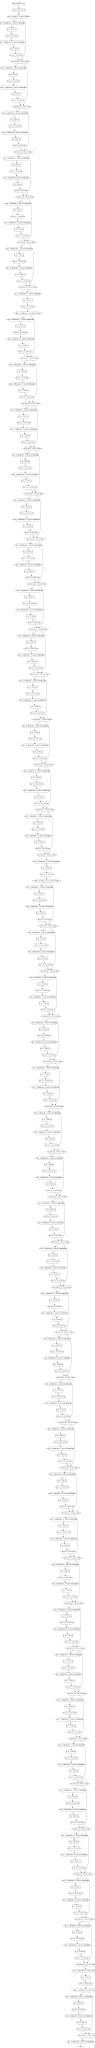

In [22]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [24]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/50
213/213 [==============================] - 532s 2s/step - loss: 1.7342 - acc: 0.5532 - val_loss: 0.5792 - val_acc: 0.4843
Epoch 2/50
213/213 [==============================] - 503s 2s/step - loss: 0.7725 - acc: 0.6998 - val_loss: 0.8389 - val_acc: 0.5261
Epoch 3/50
213/213 [==============================] - 518s 2s/step - loss: 0.7148 - acc: 0.7140 - val_loss: 1.1374 - val_acc: 0.5822
Epoch 4/50
213/213 [==============================] - 504s 2s/step - loss: 0.6631 - acc: 0.7328 - val_loss: 2.7382 - val_acc: 0.5045
Epoch 5/50
213/213 [==============================] - 497s 2s/step - loss: 0.6217 - acc: 0.7548 - val_loss: 62.4692 - val_acc: 0.3452

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
213/213 [==============================] - 499s 2s/step - loss: 0.5385 - acc: 0.7950 - val_loss: 0.4620 - val_acc: 0.7236
Epoch 7/50
213/213 [==============================] - 486s 2s/step - loss: 0.4919 - acc: 0.8085 - val_loss: 0.7454 - va

In [25]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.739623  ;  loss = 0.350999 


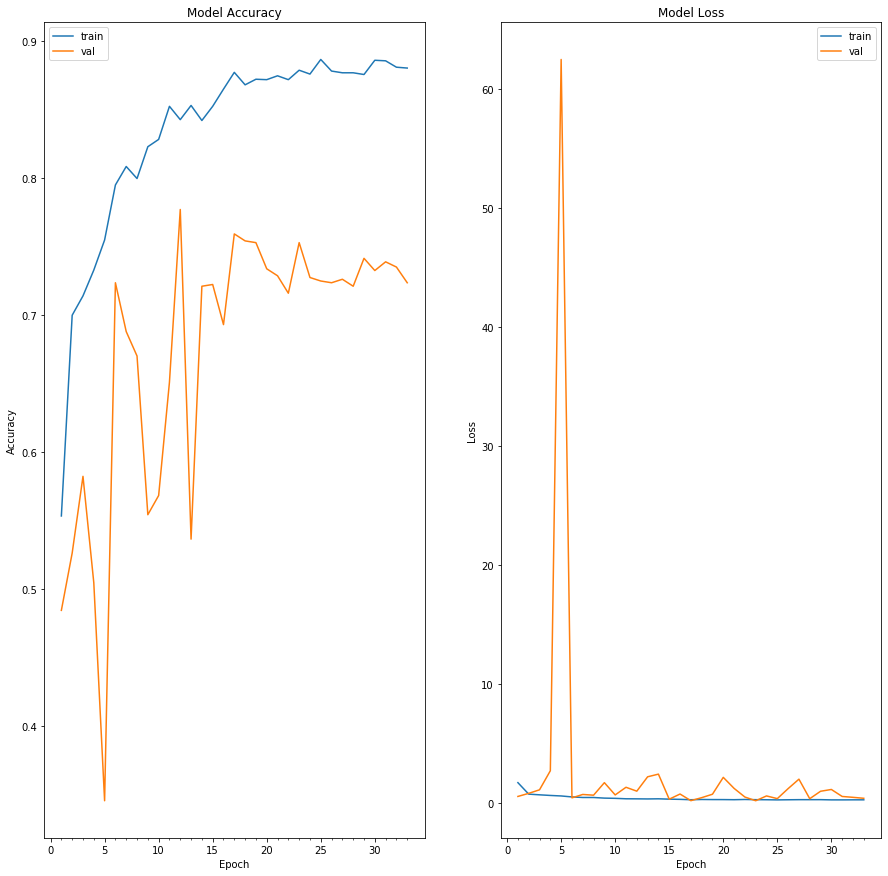

In [26]:
def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,15))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
df1['category'] =df1['category'].replace({ 'c1':0,'c2':1,'c3':2,'c4':3})
Y_val=df1['category']
Y_val =Y_val.replace({ 0:'0', 1:'1',2:'2',3:'3'})
one_hot = MultiLabelBinarizer()
Y_val = one_hot.fit_transform(Y_val)
Y_val = [ np.argmax(t) for t in Y_val ]

In [28]:
y_pred =  model.predict_generator(validation_generator)

In [29]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)
y_final = [ np.argmax(t) for t in y_final ]

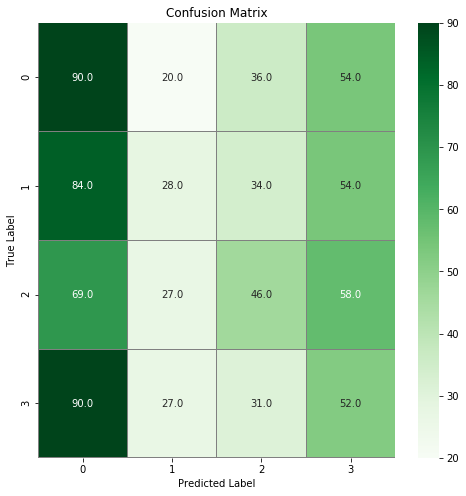

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [31]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1','2','3'])

print(report)

              precision    recall  f1-score   support

           0       0.27      0.45      0.34       200
           1       0.27      0.14      0.19       200
           2       0.31      0.23      0.27       200
           3       0.24      0.26      0.25       200

    accuracy                           0.27       800
   macro avg       0.27      0.27      0.26       800
weighted avg       0.27      0.27      0.26       800



In [32]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [33]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [34]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [35]:
test_df['category'] = np.argmax(predict, axis=-1)

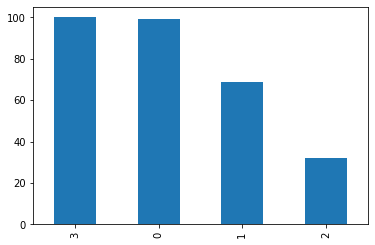

In [36]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

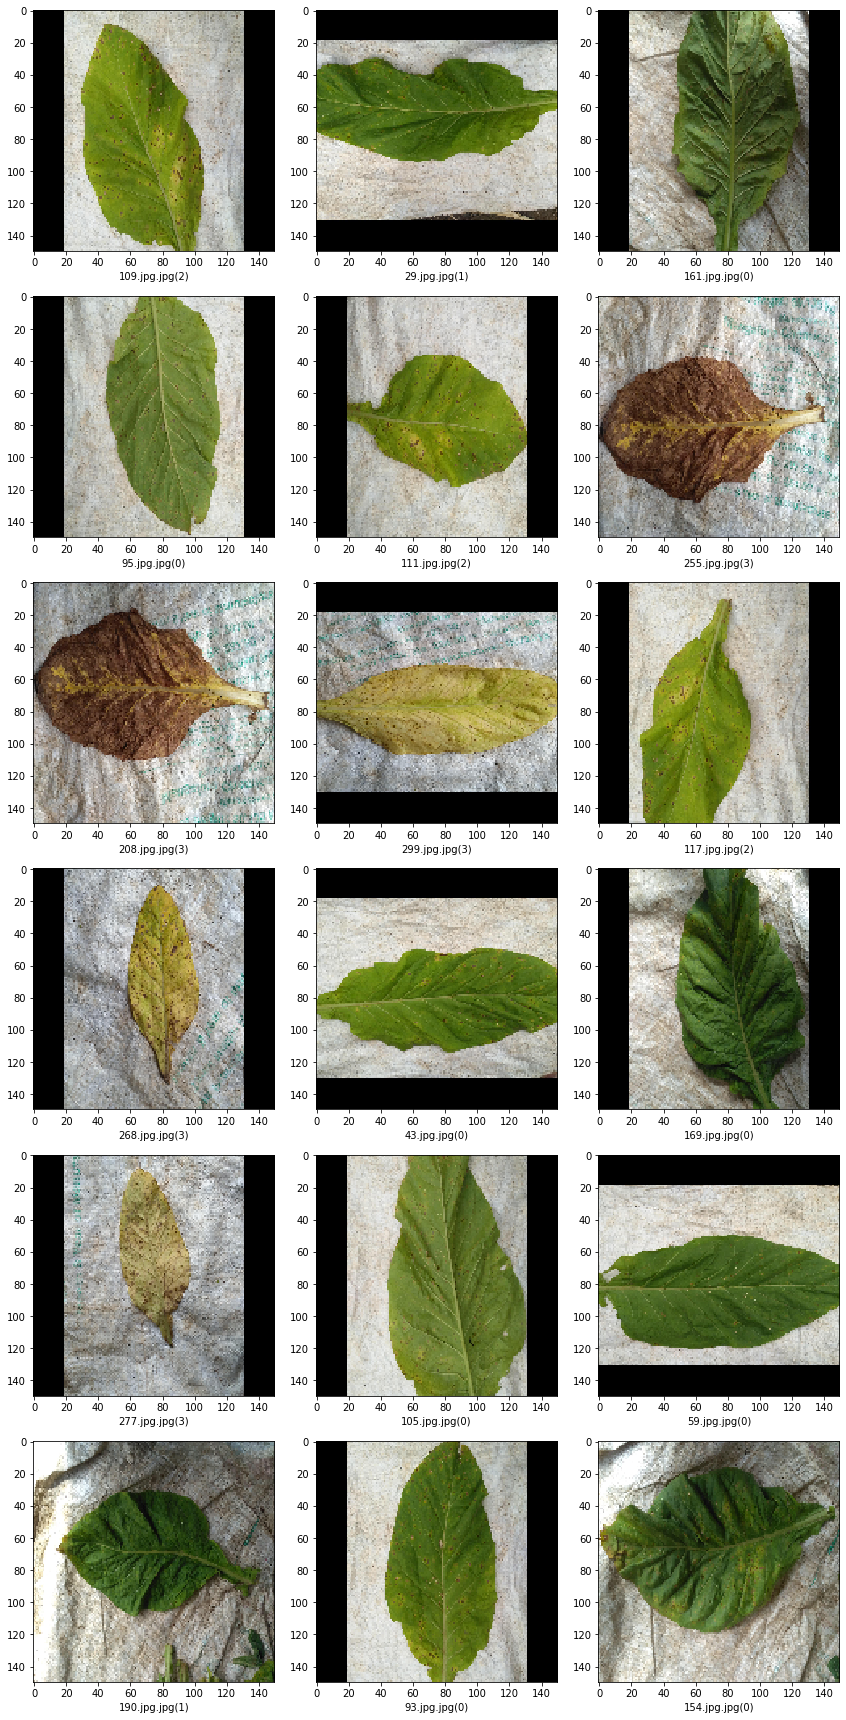

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()